# Artificial Neural Networks and Deep Learning

---
## Homework 2: Image segmentation of Mars' stones
## Team: The Backpropagators
Arianna Procaccio, Francesco Buccoliero, Kai-Xi Matteo Chen, Luca Capoferri

ariii, frbuccoliero, kaiximatteoc, luke01

246843, 245498, 245523, 259617


## ⚙️ Import Libraries

In [45]:
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import numpy as np
import tensorflow as tf
from scipy.ndimage import distance_transform_edt as distance

# ⚙️ Settings

In [46]:
seed = 888

train_ratio = 0.90
validation_ratio = 0.08
test_ratio = 0.02

IMG_SIZE = (64, 128)
NUM_CLASSES = 5

running_on = "local" # local | colab | kaggle

quick_run = True # If true skips the early plotting stuff

model_name = 'U_NET' # U_NET | U_NET_XCEPTION | UWNet | ASPP | ROCKSEG | TURKEYSEG | GROUP_NORM_UNET | LIGHT4MARS

# Training schedule
training_schedule = [
  # E.g. a first run over non-augmented data
  {
    "augmentation" : True,
    "augmentation_repetition": 1,
    "enlarge_dataset_with_custom_np_ds": False,
    "include_non_augmented": True,
    "epochs": 500,
    "batch_size": 32,
    "lr": 1e-4,
    "opt_name": "Adam", # SGD | Adam | AdamW | Lion | Ranger
  },
]

# Exponential decay
opt_exp_decay_rate: float | None = None 
opt_decay_epoch_delta = 7 # Number of epochs between each decay, if above None is not used

USE_CLASS_WEIGHTS: bool | list[int,int,int,int,int] = False # If true will use class weights for loss function, if false will use all ones, if list will use that list

loss_fn = 'sparse_categorical_crossentropy' # sparse_categorical_crossentropy | boundary_loss | dice_loss | combined_loss

FREE_MODEL = False # If true the model is deleted from memory after being dumped to file

model_filename_override = None # If not None will load the model from this file and perform inference

DATASET_PATH_LOCAL = "dataset.npz"
DATASET_PATH_COLAB = "/content/drive/MyDrive/Colab Notebooks/dataset.npz"
DATASET_PATH_KAGGLE = "/kaggle/input/dataset-h2/dataset.npz"

OUTLIER_MASK_LOCAL = "outlier_mask.npy"
OUTLIER_MASK_COLAB = "/content/drive/MyDrive/Colab Notebooks/outlier_mask.npy"
OUTLIER_MASK_KAGGLE = "/kaggle/input/dataset-h2/outlier_mask.npy"

In [47]:
# Define here the Albumentation pipeline to be used for augmentation

def build_augmentation():
  # For Matteo, do not delete
  transform = A.Compose([
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.HorizontalFlip(p=0.5),  # Horizontal flip for diverse texture representation
    A.VerticalFlip(p=0.5),  # Vertical flip to simulate different orientations
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
  ])
  
  return transform

In [48]:
# A custom augmentation for some specific targets (e.g. images with a lot of background)
def build_augmentation_bg():
  transform = A.Compose([
      A.RandomRotate90(p=0.5),  # Random 90-degree rotation
      A.HorizontalFlip(p=0.5),  # Horizontal flip for diverse texture representation
      A.VerticalFlip(p=0.5),  # Vertical flip to simulate different orientations
      A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
    ])
  return transform

In [49]:
# Loading configurations based on the given settings
assert train_ratio + validation_ratio + test_ratio == 1

np.random.seed(seed)
tf.random.set_seed(seed)

DATASET_PATH = DATASET_PATH_LOCAL if running_on == "local" else DATASET_PATH_COLAB if running_on == "colab" else DATASET_PATH_KAGGLE
OUTLIER_MASK = OUTLIER_MASK_LOCAL if running_on == "local" else OUTLIER_MASK_COLAB if running_on == "colab" else OUTLIER_MASK_KAGGLE

data = np.load(DATASET_PATH)
outlier_mask_template = np.load(OUTLIER_MASK) # discovered by hand

## ⏳ Load, inspect and prepare the data

In [50]:
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

hidden_X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test hidden X shape: {hidden_X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255
X_train = X_train.astype(np.float32)
hidden_X_test = hidden_X_test[..., np.newaxis] / 255
hidden_X_test = hidden_X_test.astype(np.float32)

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Split train and validation
validation_size = int(X_train.shape[0] * validation_ratio)

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# Define train and validation indices
split_indices = [int(X_train.shape[0] * train_ratio), int(X_train.shape[0] * (train_ratio + validation_ratio))]

X_train, X_val, X_test = np.split(X_train, split_indices)
y_train, y_val, y_test = np.split(y_train, split_indices)

print("======= BEFORE REMOVING OUTLIERS =======")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

# Outliers share the mask
train_outliers_indices = [i for i, img in enumerate(y_train) if not np.array_equal(img, outlier_mask_template)]
val_outliers_indices = [i for i, img in enumerate(y_val) if not np.array_equal(img, outlier_mask_template)]
test_outliers_indices = [i for i, img in enumerate(y_test) if not np.array_equal(img, outlier_mask_template)]
print(f'Total outliers in train set: {y_train.shape[0] - len(train_outliers_indices)}')
print(f'Total outliers in validation set: {y_val.shape[0] - len(val_outliers_indices)}')
print(f'Total outliers in test set: {y_test.shape[0] - len(test_outliers_indices)}')

# Remove outlier from train and validation set
X_train = X_train[train_outliers_indices]
y_train = y_train[train_outliers_indices]
X_val = X_val[val_outliers_indices]
y_val = y_val[val_outliers_indices]
X_test = X_test[test_outliers_indices]
y_test = y_test[test_outliers_indices]

print("======= AFTER REMOVING OUTLIERS =======")
print(f'Updated train dataset size: {X_train.shape}')
print(f'Updated validation dataset size: {X_val.shape}')
print(f'Updated test dataset size: {X_test.shape}')

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test hidden X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5
======= BEFORE REMOVING OUTLIERS =======
Training X shape: (2353, 64, 128, 1)
Training y shape: (2353, 64, 128)
Validation X shape: (209, 64, 128, 1)
Validation y shape: (209, 64, 128)
Test X shape: (53, 64, 128, 1)
Test y shape: (53, 64, 128)
Total outliers in train set: 105
Total outliers in validation set: 4
Total outliers in test set: 1
======= AFTER REMOVING OUTLIERS =======
Updated train dataset size: (2248, 64, 128, 1)
Updated validation dataset size: (205, 64, 128, 1)
Updated test dataset size: (52, 64, 128, 1)


In [51]:
# Retrieve images with a lot of label labels
def retrieve_imgs_of_label(X, y, bg_label_min_percentage=0.9, label=0):
  tot_pixels = IMG_SIZE[0] * IMG_SIZE[1]
  imgs = []
  labels = []
  # Count pixels for each class
  for label_image, img in zip(y, X):
    unique, counts = np.unique(label_image, return_counts=True)
    for u, c in zip(unique, counts):
      #print(u, c)
      #if (int(u) == 0):
      #  print('z', c)
      if int(u) == label and c / tot_pixels >= bg_label_min_percentage:
        imgs.append(img)
        labels.append(label_image)
  return np.array(imgs), np.array(labels)

bg_imgs, bg_labels = retrieve_imgs_of_label(X_train, y_train, bg_label_min_percentage=0.65)
print('Retrieved images:', bg_imgs.shape[0], 'with at least 65% of label 0')

Retrieved images: 344 with at least 65% of label 0


In [ ]:
# Plot the data. The number of images being displayed are rows X cols
def plot(data, mask=None, num_images=10, rows=4, cols=8, num_cls=5, colors=None):
  # Reshape if needed (e.g., remove channel dimension for grayscale images)
  if data.shape[-1] == 1:  # Grayscale case
    data = data.squeeze(axis=-1)  # Remove channel dimension
  
  if mask is None:
    # Plot settings
    _, axes = plt.subplots(rows, cols, figsize=(12, 6))  # Adjust figure size as needed
  
    # Display images
    for i, ax in enumerate(axes.flat):
      if i < len(data):  # Check if there are enough images
        ax.imshow(data[i], cmap='gray' if len(data[i].shape) == 2 else None)
        ax.axis('off')  # Hide axes
      else:
        ax.axis('off')  # Hide any empty subplot
  
    plt.tight_layout()
    plt.show()
  else:

    # Define custom colors for each class
    import matplotlib.colors as mcolors
    if num_cls == 2:
      class_colors = ["blue", "purple"] if colors is None else colors
    elif num_classes == 5:
      class_colors = ["purple", "blue", "green", "orange", "yellow"] if colors is None else colors
    else:
      raise RuntimeError('Not impl')
    cmap = mcolors.ListedColormap(class_colors)

    # Define normalization to map class values to the color map
    bounds = np.arange(num_cls + 1) - 0.5  # Create boundaries for each class
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    num_samples = num_images  # Number of images to display
    if num_samples < 4:
      num_samples = 4

    # Plot settings
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))

    for i in range(num_samples):
      # Original image
      axes[i, 0].imshow(data[i], cmap="gray")
      axes[i, 0].set_title(f"Image {i+1}")
      axes[i, 0].axis("off")

      # Corresponding mask
      axes[i, 1].imshow(mask[i], cmap=cmap, alpha=0.8)  # Adjust cmap as needed
      axes[i, 1].set_title(f"Mask {i+1}")
      axes[i, 1].axis("off")
    # Add a colorbar
    cbar = fig.colorbar(
      plt.cm.ScalarMappable(cmap=cmap, norm=norm),
      ax=axes[:, 1],  # Align the colorbar with the mask columns
      orientation="vertical",
      fraction=0.02,
      pad=0.04
    )
    cbar.set_ticks(np.arange(num_cls))  # Set tick locations
    cbar.set_ticklabels([f"Class {i}" for i in range(num_cls)])  # Set tick labels

    #plt.tight_layout()
    plt.show()

In [53]:
if not quick_run:
  plot(X_train, rows=10, cols=8)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

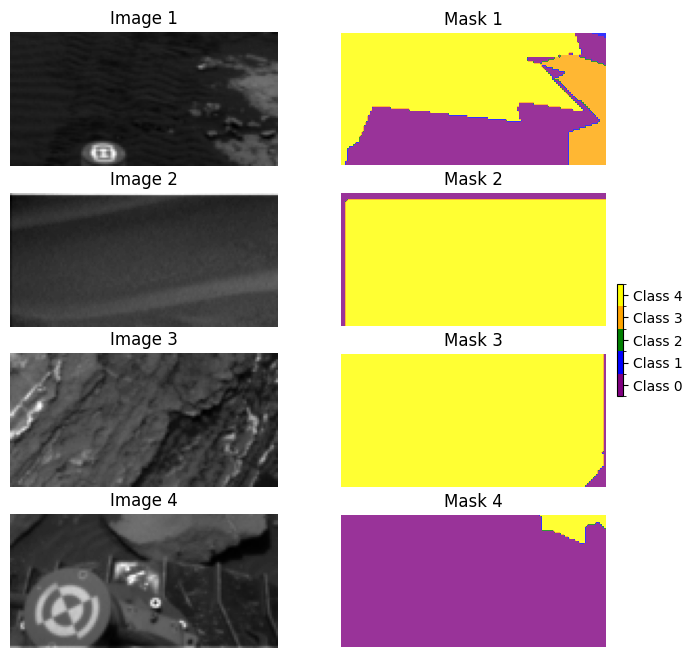

In [ ]:
# An additional check: you should not see any outlier
prev_qr = quick_run
quick_run = False
if not quick_run:
  print(y_train[0][0,:])
  print(y_train[1][-1,:])
  print(y_train[2][-1,:])
  plot(X_train, mask=y_train, num_images=4)
quick_run = prev_qr

In [ ]:
def check_class_distribution(label_dataset, num_classes):
  # Initialize counts for each class
  class_counts = np.zeros(num_classes)

  # Count pixels for each class
  for label_image in label_dataset:
      unique, counts = np.unique(label_image, return_counts=True)
      for u, c in zip(unique, counts):
          class_counts[u] += c

  # Normalize counts (percentage)
  total_pixels = np.sum(class_counts)
  class_distribution = class_counts / total_pixels * 100

  # Print and visualize
  print("Class Distribution (% of pixels):")
  for i in range(num_classes):
      print(f"Class {i}: {class_distribution[i]:.2f}%")
  
  if not quick_run:
    # Plot class distribution
    plt.bar(range(num_classes), class_distribution, tick_label=[f"Class {i}" for i in range(num_classes)])
    plt.xlabel("Classes")
    plt.ylabel("Percentage of Pixels")
    plt.title("Class Distribution")
    plt.show()
  
  return class_distribution

def get_class_weights(class_distribution):
  # Convert percentage to class probabilities
  class_probabilities = np.array(class_distribution) / 100.0

  # Calculate class weights (inverse of class probability)
  class_weights = 1.0 / class_probabilities

  # Normalize weights (optional, you can skip normalization if desired)
  max_weight = np.max(class_weights)
  class_weights = class_weights / max_weight  # Normalize to have the maximum weight = 1

  return {i:w for i,w in enumerate(class_weights)}

# Check for 5 classes (class IDs: 0-4)
class_distribution = check_class_distribution([e.astype(np.int8) for e in y_train], num_classes=num_classes)

if type(USE_CLASS_WEIGHTS) == bool:
  if USE_CLASS_WEIGHTS:
    class_weights = get_class_weights(class_distribution)
  else:
    class_weights = {i: 1.0/num_classes for i in range(num_classes)}
else:
  class_weights = {i: w for i, w in enumerate(USE_CLASS_WEIGHTS)}

print('Class weights:', class_weights)

In [ ]:
# `concat_and_shuffle_aug_with_no_aug` will double the X_train size
# `remove_bg` will set all the bg pixels to dark
# `augmentation_repetition` will concatenate n times the augmented dataset by applying the same `augmentations` fn. Useful for augmentation pipeline with probability activations
def get_dataset(X, y, batch_size=32, augmentations=None, augmentation_repetition=1, **kwargs):

  def resize_img_and_mask(img, mask):
    input_img = tf.image.resize(img, IMG_SIZE)
    input_img = tf.cast(input_img, tf.float32)

    # Resize needs at least 3 dims, add a dummy one
    if kwargs.get('one_hot', False):
      mask = tf.cast(mask, tf.int32)
      target_img = tf.one_hot(mask, depth=num_classes, axis=-1)
    else:
      target_img = tf.expand_dims(mask, axis=-1)
    # Nearest-neighbor is essential for resizing segmentation masks because it preserves the discrete class labels (e.g., 0, 1, 2) without introducing unintended values due to interpolation
    target_img = tf.image.resize(target_img, IMG_SIZE, method="nearest")
    target_img = tf.cast(target_img, tf.int32) # Consider lower integers

    return input_img, target_img

  def remove_background(image, mask, background_label=0):
    background_mask = (mask == background_label)
    image[background_mask] = 0  # Set to black
    return image, mask

  def apply_augmentation_np():
    X_a = []
    y_a = []
    for i, m in zip(X, y):
      aug_img, aug_mask = augmentations(i, m)
      if kwargs.get('remove_bg', False):
        aug_img, aug_mask = remove_background(aug_img, aug_mask)
      X_a.append(aug_img)  
      y_a.append(aug_mask)  
    return np.array(X_a), np.array(y_a)
  
  if kwargs.get('remove_bg', False):
    X_a = []
    y_a = []
    for i, m in zip(X, y):
      aug_img, aug_mask = remove_background(i, m)
      X_a.append(aug_img)
      y_a.append(aug_mask)
    X = np.array(X_a)
    y = np.array(y_a)

  # Apply augmentations before converting to dataset (this will be serial I think but we avoid type conversions as A works on np arrays)
  if augmentations is not None:
    X_a, y_a = apply_augmentation_np()
    dataset = tf.data.Dataset.from_tensor_slices((X_a, y_a))
    if augmentation_repetition > 1:
      for i in range(augmentation_repetition-1):
        X_a, y_a = apply_augmentation_np()
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X_a, y_a)))
    add_len = 0
    if kwargs.get('additional_ds_concat', None):
      # Optimistic
      add_len = len(kwargs['additional_ds_concat'])
      for pair in kwargs['additional_ds_concat']:
        print('concatenating additional ds')
        images, labels = pair
        images = images.astype(np.float32)
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((images, labels)))
    if kwargs.get('concat_and_shuffle_aug_with_no_aug', False):
      dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X, y)))
      dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+1+add_len))
    else:
      dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+add_len))

  else:
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    add_len = 0
    if kwargs.get('additional_ds_concat', None):
      # Optimistic
      add_len = len(kwargs['additional_ds_concat'])
      for pair in kwargs['additional_ds_concat']:
        print('concatenating additional ds')
        images, labels = pair
        images = images.astype(np.float32)
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((images, labels)))
    dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (add_len+1))

  dataset = dataset.map(resize_img_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
# Enlarge dataset containing images provided in the inputs
def get_enlarged_dataset(imgs, labels, aug_fn, repetitions=2, unbatch=True, np_ds=True):
  def apply_aug(img, mask):
    transform = aug_fn()
    transformed = transform(image=img, mask=mask)
    return transformed["image"], transformed["mask"]
  if np_ds:
    X_a = []
    y_a = []
    for _ in range(repetitions):
      for i, m in zip(imgs, labels):
        aug_img, aug_mask = apply_aug(i, m)
        X_a.append(aug_img)  
        y_a.append(aug_mask)  
    return np.array(X_a), np.array(y_a)
  else:
    enlarged_bg_dataset = get_dataset(imgs, labels, augmentations=apply_aug, augmentation_repetition=repetitions)
    # We unbatch as this will be concatenated with other ds
    if unbatch:
      ds = enlarged_bg_dataset.unbatch()
    return ds

In [ ]:
# Try the enlarged bg images dataset as example
if not quick_run:
  N = 10
  a, b =  get_enlarged_dataset(bg_imgs[:N], bg_labels[:N], build_augmentation_bg, np_ds=True)
  print(a.shape, b.shape)
  plot(a, mask=b, num_images=N)


## 🎲 Define training configuration

In [ ]:

def compute_signed_distance_map(mask):
  
  # Calcola la distanza esterna (distanza dai bordi del foreground)
  inv_mask = 1 - mask
  dist_out = tf.cast(tf.nn.relu(tf.image.sobel_edges(inv_mask)), tf.float32)

  # Calcola la distanza interna (distanza dai bordi del background)
  dist_in = tf.cast(tf.nn.relu(tf.image.sobel_edges(mask)), tf.float32)

  # Combina le distanze in un unico gradiente
  dx_out, dy_out = dist_out[..., 0], dist_out[..., 1]
  dx_in, dy_in = dist_in[..., 0], dist_in[..., 1]

  dist_out_combined = tf.sqrt(tf.square(dx_out) + tf.square(dy_out))
  dist_in_combined = tf.sqrt(tf.square(dx_in) + tf.square(dy_in))

  # Signed Distance Map: negativo all'interno, positivo all'esterno
  sdm = dist_out_combined - dist_in_combined
  return sdm

def boundary_loss(y_true, y_pred):
  # Calcola la Signed Distance Map
  sdm = compute_signed_distance_map(y_true)
  
  # Normalizza le previsioni
  y_pred = tf.nn.softmax(y_pred, axis=-1)

  # Calcola la boundary loss
  loss = tf.reduce_mean(tf.abs(sdm * (y_true - y_pred)))
  
  return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
  # Convert y_true to one-hot if needed
  # TODO: should we retrieve the argmax and use 1 channels instead of 5?
  if y_true.shape[-1] != y_pred.shape[-1]:
    y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
  
  # Compute Dice Loss per class
  intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
  union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
  dice = (2. * intersection + smooth) / (union + smooth)
  
  # Average Dice Loss over all classes and batch
  dice_loss = 1 - tf.reduce_mean(dice)
  
  return dice_loss


def combined_loss(y_true, y_pred):
    alpha = 0.3
    beta = 0.3
    gamma = 1 - alpha - beta

    loss_sparse = tfk.losses.sparse_categorical_crossentropy(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
  
    if y_true.shape[-1] != y_pred.shape[-1]:
      y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
    loss_boundary = boundary_loss(y_true, y_pred)
    focal_loss = tfk.losses.CategoricalFocalCrossentropy() 
    loss_focal = focal_loss(y_true, y_pred)

    return (
      alpha * loss_dice +
      beta * loss_focal +
      gamma * loss_boundary
    )

def get_loss():
  if loss_fn == 'sparse_categorical_crossentropy':
    return tfk.losses.SparseCategoricalCrossentropy()
  elif loss_fn == 'boundary_loss':
    return boundary_loss
  elif loss_fn == 'dice_loss':
    return dice_loss
  elif loss_fn == 'combined_loss':
    return combined_loss
  else:
    raise ValueError(f"Loss function {loss_fn} not recognized")


In [ ]:
# Visualization callback
category_map = {
  0: 0, # Background,
  1: 1, # Soil,
  2: 2, # Bedrock,
  3: 3, # Sand,
  4: 4, # Big Rock,
}

def apply_category_mapping(label):
  """
  Apply category mapping to labels.
  """
  print("Label dtype before mapping:", label.dtype)
  keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
  vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
  table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0
  )
  return table.lookup(label)

def create_segmentation_colormap(num_classes):
  """
  Create a linear colormap using a predefined palette.
  Uses 'viridis' as default because it is perceptually uniform
  and works well for colorblindness.
  """
  return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
  """
  Apply the colormap to a label.
  """
  # Ensure label is 2D
  label = np.squeeze(label)

  if colormap is None:
    num_classes = len(np.unique(label))
    colormap = create_segmentation_colormap(num_classes)

  # Apply the colormap
  colored = colormap[label.astype(int)]

  return colored
  
class VizCallback(tf.keras.callbacks.Callback):
  def __init__(self, image, label, frequency=5):
    super().__init__()
    self.image = image
    self.label = tf.cast(tf.convert_to_tensor(label), tf.int32) 
    self.frequency = frequency

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
      image, label = self.image, self.label
      label = apply_category_mapping(label)
      image = tf.expand_dims(image, 0)
      pred = self.model.predict(image, verbose=0)
      y_pred = tf.math.argmax(pred, axis=-1)
      y_pred = y_pred.numpy()

      # Create colormap
      num_classes = NUM_CLASSES
      colormap = create_segmentation_colormap(num_classes)

      plt.figure(figsize=(16, 4))

      # Input image
      plt.subplot(1, 3, 1)
      plt.imshow(image[0],cmap='gray')
      plt.title("Input Image")
      plt.axis('off')

      # Ground truth
      plt.subplot(1, 3, 2)
      colored_label = apply_colormap(label.numpy(), colormap)
      plt.imshow(colored_label)
      plt.title("Ground Truth Mask")
      plt.axis('off')

      # Prediction
      plt.subplot(1, 3, 3)
      colored_pred = apply_colormap(y_pred[0], colormap)
      plt.imshow(colored_pred)
      plt.title("Predicted Mask")
      plt.axis('off')

      plt.tight_layout()
      plt.show()
      plt.close()

In [ ]:
# Define fitting callbacks. Comment out from dict the unwanted ones
val_mask = tf.expand_dims(y_val[0], axis=-1)
val_mask = tf.image.resize(val_mask, [IMG_SIZE[0], IMG_SIZE[1]], method="nearest")
val_img = tf.image.resize(X_val[0], [IMG_SIZE[0], IMG_SIZE[1]])
viz_callback = VizCallback(val_img, val_mask)
model_fit_callbacks = {
  'ReduceLROnPlateau': tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=25, min_lr=1e-6, verbose=1),
  'EarlyStopping': tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=50, restore_best_weights=True, verbose=1),
  'Viz_callback' : viz_callback
}

def get_callbacks():
  return [i for i in model_fit_callbacks.values()]

## 🛠️ Define model, augmentation and utils builders

In [ ]:
def apply_augmentation(img, mask):
  transform = build_augmentation()
  transformed = transform(image=img, mask=mask)
  return transformed["image"], transformed["mask"]


In [ ]:
# Try the augmented dataset
if not quick_run:
  N = 2
  ds = get_dataset(X_train[:N], y_train[:N], augmentations=apply_augmentation, augmentation_repetition=4, concat_and_shuffle_aug_with_no_aug=True)

  for batch in ds.take(1):
    a, b = batch
    plot(a.numpy(), b.numpy(), num_images=N * 5) # use N * (augmentation_repetition+1) as `concat_and_shuffle_aug_with_no_aug` is True 
    break


In [ ]:
# taken from https://keras.io/examples/vision/oxford_pets_image_segmentation/
def build_U_NET_XCEPTION(img_size: tuple[int, int, int], num_classes):
  inputs = tfk.Input(shape=img_size) # One channel input

  ### [First half of the network: downsampling inputs] ###

  # Entry block
  x = tfkl.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256]:
    x = tfkl.Activation("relu")(x)
    x = tfkl.SeparableConv2D(filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Activation("relu")(x)
    x = tfkl.SeparableConv2D(filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = tfkl.Conv2D(filters, 1, strides=2, padding="same")(
    previous_block_activation
    )
    x = tfkl.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs] ###

  for filters in [256, 128, 64, 32]:
    x = tfkl.Activation("relu")(x)
    x = tfkl.Conv2DTranspose(filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Activation("relu")(x)
    x = tfkl.Conv2DTranspose(filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.UpSampling2D(2)(x)

    # Project residual
    residual = tfkl.UpSampling2D(2)(previous_block_activation)
    residual = tfkl.Conv2D(filters, 1, padding="same")(residual)
    x = tfkl.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Add a per-pixel classification layer
  outputs = tfkl.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

  # Define the model
  model = tfk.Model(inputs, outputs, name='UNetXception')
  return model

In [ ]:
def build_U_NET(img_size: tuple[int, int, int], num_classes):
  def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

  input_layer = tfkl.Input(shape=img_size, name='input_layer')

  # Downsampling path
  down_block_1 = unet_block(input_layer, 32, name='down_block1_')
  d1 = tfkl.MaxPooling2D()(down_block_1)

  down_block_2 = unet_block(d1, 64, name='down_block2_')
  d2 = tfkl.MaxPooling2D()(down_block_2)

  # Bottleneck
  bottleneck = unet_block(d2, 128, name='bottleneck')

  # Upsampling path
  u1 = tfkl.UpSampling2D()(bottleneck)
  u1 = tfkl.Concatenate()([u1, down_block_2])
  u1 = unet_block(u1, 64, name='up_block1_')

  u2 = tfkl.UpSampling2D()(u1)
  u2 = tfkl.Concatenate()([u2, down_block_1])
  u2 = unet_block(u2, 32, name='up_block2_')

  # Output Layer
  if num_classes==1:
    output_layer = tfkl.Conv2D(1, kernel_size=1, padding='same', activation="sigmoid", name='output_layer')(u2)
  else:
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
  return model

In [ ]:
def build_GROUP_NORM_UNET(img_size: tuple[int, int, int], num_classes: int, groups=8):
  """U-NET architecture using Group Normalization instead of Batch Normalization"""
  def conv_group_norm_block(input_tensor, filters, kernel_size=3, groups=8, activation='relu', stack=2, name=''):
    x = input_tensor
    
    for i in range(stack):
      x = tfkl.Conv2D(
        filters, 
        kernel_size=kernel_size, 
        padding='same', 
        name=name + f'conv{i + 1}'
      )(x)
      x = tfkl.GroupNormalization(
        groups=min(groups, filters), # Cannot have more groups than channels
        name=name + f'gn{i + 1}'
      )(x)
      x = tfkl.Activation(activation, name=name + f'activation{i + 1}')(x)
      
    return x

  input_layer = tfkl.Input(shape=img_size, name='input_layer')

  # Downsampling path
  down_block_1 = conv_group_norm_block(input_layer, 64, groups=groups, name='down_block1_')
  d1 = tfkl.MaxPooling2D()(down_block_1)

  down_block_2 = conv_group_norm_block(d1, 128, groups=groups, name='down_block2_')
  d2 = tfkl.MaxPooling2D()(down_block_2)

  down_block_3 = conv_group_norm_block(d2, 256, groups=groups, name='down_block3_')
  d3 = tfkl.MaxPooling2D()(down_block_3)

  # Bottleneck
  bottleneck = conv_group_norm_block(d3, 512, groups=groups, name='bottleneck')
  bottleneck = tfkl.Dropout(0.3)(bottleneck)

  # Upsampling path
  u1 = tfkl.UpSampling2D()(bottleneck)
  u1 = tfkl.Concatenate()([u1, down_block_3])
  u1 = conv_group_norm_block(u1, 256, groups=groups, name='up_block1_')
  u1 = tfkl.Dropout(0.2)(u1)

  u2 = tfkl.UpSampling2D()(u1)
  u2 = tfkl.Concatenate()([u2, down_block_2])
  u2 = conv_group_norm_block(u2, 128, groups=groups, name='up_block2_')
  u2 = tfkl.Dropout(0.2)(u2)

  u3 = tfkl.UpSampling2D()(u2)
  u3 = tfkl.Concatenate()([u3, down_block_1])
  u3 = conv_group_norm_block(u3, 64, groups=groups, name='up_block3_')
  u3 = tfkl.Dropout(0.1)(u3)

  # Output Layer
  output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='GroupNormUNet')
  return model

In [ ]:
def build_ATTENTION_UW_NET(img_size: tuple[int, int, int], num_classes):
  def attention_block(x, g, inter_channel):
    # theta_x (bs, h, w, inter_channel)
    theta_x = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    
    # phi_g (bs, h, w, inter_channel)
    phi_g = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(g)
    
    # f (bs, h, w, 1)
    f = tfkl.Activation('relu')(tfkl.Add()([theta_x, phi_g]))
    psi_f = tfkl.Conv2D(1, [1, 1], strides=[1, 1])(f)
    
    # sigmoid_psi_f (bs, h, w, 1)
    sigmoid_psi_f = tfkl.Activation('sigmoid')(psi_f)
    
    # rate (bs, h, w, 1)
    rate = tfkl.multiply([x, sigmoid_psi_f])
    
    return rate
  
  # Input
  inputs = tfkl.Input(shape=img_size)
  
  # Encoder Path
  # Block 1
  conv1 = tfkl.Conv2D(64, 3, padding='same')(inputs)
  conv1 = tfkl.BatchNormalization()(conv1)
  conv1 = tfkl.Activation('relu')(conv1)
  conv1 = tfkl.Conv2D(64, 3, padding='same')(conv1)
  conv1 = tfkl.BatchNormalization()(conv1)
  conv1 = tfkl.Activation('relu')(conv1)
  pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)
  
  # Block 2
  conv2 = tfkl.Conv2D(128, 3, padding='same')(pool1)
  conv2 = tfkl.BatchNormalization()(conv2)
  conv2 = tfkl.Activation('relu')(conv2)
  conv2 = tfkl.Conv2D(128, 3, padding='same')(conv2)
  conv2 = tfkl.BatchNormalization()(conv2)
  conv2 = tfkl.Activation('relu')(conv2)
  pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)
  
  # Block 3
  conv3 = tfkl.Conv2D(256, 3, padding='same')(pool2)
  conv3 = tfkl.BatchNormalization()(conv3)
  conv3 = tfkl.Activation('relu')(conv3)
  conv3 = tfkl.Conv2D(256, 3, padding='same')(conv3)
  conv3 = tfkl.BatchNormalization()(conv3)
  conv3 = tfkl.Activation('relu')(conv3)
  pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)
  
  # Block 4
  conv4 = tfkl.Conv2D(512, 3, padding='same')(pool3)
  conv4 = tfkl.BatchNormalization()(conv4)
  conv4 = tfkl.Activation('relu')(conv4)
  conv4 = tfkl.Conv2D(512, 3, padding='same')(conv4)
  conv4 = tfkl.BatchNormalization()(conv4)
  conv4 = tfkl.Activation('relu')(conv4)
  pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv4)
  
  # Bridge
  conv5 = tfkl.Conv2D(1024, 3, padding='same')(pool4)
  conv5 = tfkl.BatchNormalization()(conv5)
  conv5 = tfkl.Activation('relu')(conv5)
  conv5 = tfkl.Conv2D(1024, 3, padding='same')(conv5)
  conv5 = tfkl.BatchNormalization()(conv5)
  conv5 = tfkl.Activation('relu')(conv5)
  
  # Decoder Path with Attention
  # Block 6
  up6 = tfkl.Conv2D(512, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv5))
  up6 = tfkl.BatchNormalization()(up6)
  up6 = tfkl.Activation('relu')(up6)
  
  att6 = attention_block(conv4, up6, inter_channel=256)
  merge6 = tfkl.concatenate([att6, up6], axis=3)
  
  conv6 = tfkl.Conv2D(512, 3, padding='same')(merge6)
  conv6 = tfkl.BatchNormalization()(conv6)
  conv6 = tfkl.Activation('relu')(conv6)
  conv6 = tfkl.Conv2D(512, 3, padding='same')(conv6)
  conv6 = tfkl.BatchNormalization()(conv6)
  conv6 = tfkl.Activation('relu')(conv6)
  
  # Block 7
  up7 = tfkl.Conv2D(256, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv6))
  up7 = tfkl.BatchNormalization()(up7)
  up7 = tfkl.Activation('relu')(up7)
  
  att7 = attention_block(conv3, up7, inter_channel=128)
  merge7 = tfkl.concatenate([att7, up7], axis=3)
  
  conv7 = tfkl.Conv2D(256, 3, padding='same')(merge7)
  conv7 = tfkl.BatchNormalization()(conv7)
  conv7 = tfkl.Activation('relu')(conv7)
  conv7 = tfkl.Conv2D(256, 3, padding='same')(conv7)
  conv7 = tfkl.BatchNormalization()(conv7)
  conv7 = tfkl.Activation('relu')(conv7)
  
  # Block 8
  up8 = tfkl.Conv2D(128, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv7))
  up8 = tfkl.BatchNormalization()(up8)
  up8 = tfkl.Activation('relu')(up8)
  
  att8 = attention_block(conv2, up8, inter_channel=64)
  merge8 = tfkl.concatenate([att8, up8], axis=3)
  
  conv8 = tfkl.Conv2D(128, 3, padding='same')(merge8)
  conv8 = tfkl.BatchNormalization()(conv8)
  conv8 = tfkl.Activation('relu')(conv8)
  conv8 = tfkl.Conv2D(128, 3, padding='same')(conv8)
  conv8 = tfkl.BatchNormalization()(conv8)
  conv8 = tfkl.Activation('relu')(conv8)
  
  # Block 9
  up9 = tfkl.Conv2D(64, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv8))
  up9 = tfkl.BatchNormalization()(up9)
  up9 = tfkl.Activation('relu')(up9)
  
  att9 = attention_block(conv1, up9, inter_channel=32)
  merge9 = tfkl.concatenate([att9, up9], axis=3)
  
  conv9 = tfkl.Conv2D(64, 3, padding='same')(merge9)
  conv9 = tfkl.BatchNormalization()(conv9)
  conv9 = tfkl.Activation('relu')(conv9)
  conv9 = tfkl.Conv2D(64, 3, padding='same')(conv9)
  conv9 = tfkl.BatchNormalization()(conv9)
  conv9 = tfkl.Activation('relu')(conv9)
  
  # Output
  if num_classes == 1:
    outputs = tfkl.Conv2D(1, 1, activation='sigmoid')(conv9)
  else:
    outputs = tfkl.Conv2D(num_classes, 1, activation='softmax')(conv9)
  
  model = tfk.Model(inputs=inputs, outputs=outputs, name='AttentionUWNet')
  return model

In [ ]:
def build_ASPP_model(img_size: tuple[int, int, int], num_classes: int):
  
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.l2(1e-4)

  inputs = tfkl.Input(shape=img_size)

  def conv_block(x, filters, kernel_size=(3, 3), activation="relu", batch_norm=True, dropout_rate=0.2):
    x = tfkl.Conv2D(
      filters,
      kernel_size,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    if batch_norm:
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(activation)(x)
    if dropout_rate > 0:
      x = tfkl.SpatialDropout2D(dropout_rate)(x)
    return x

  def encoder_block(x, filters, dropout_rate=0.2):
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    p = tfkl.MaxPooling2D(2)(x)
    return x, p

  def atrous_spatial_pyramid_pooling(x, dropout_rate=0.3):
    dims = x.shape[1:3]
    pool = tfkl.GlobalAveragePooling2D()(x)
    pool = tfkl.Reshape((1, 1, x.shape[-1]))(pool)
    pool = tfkl.Conv2D(
      256, 
      1, 
      padding="same", 
      kernel_initializer=initializer, 
      kernel_regularizer=regularizer,
    )(pool)
    pool = tfkl.UpSampling2D(size=dims, interpolation="bilinear")(pool)
    pool = tfkl.SpatialDropout2D(dropout_rate)(pool)

    conv_1x1 = tfkl.Conv2D(
      256,
      1,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_6 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=6,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_12 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=12,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_18 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=18,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)

    x = tfkl.Concatenate()([pool, conv_1x1, atrous_6, atrous_12, atrous_18])
    x = tfkl.Conv2D(
      256,
      1,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    x = tfkl.SpatialDropout2D(dropout_rate)(x)
    return x

  def decoder_block(x, skip, filters, dropout_rate=0.2):
    x = tfkl.Conv2DTranspose(
      filters,
      2,
      strides=2,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    x = tfkl.Concatenate()([x, skip])
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    return x

  # Encoder
  filters = [64, 128, 256, 512]
  skips = []
  x = inputs
  for f in filters:
    skip, x = encoder_block(x, f, dropout_rate=0.2)
    skips.append(skip)

  # Bottleneck with ASPP
  x = conv_block(x, 1024, dropout_rate=0.3)
  x = atrous_spatial_pyramid_pooling(x, dropout_rate=0.3)

  # Decoder
  skips = skips[::-1]
  decoder_filters = [512, 256, 128, 64]
  for skip, f in zip(skips, decoder_filters):
    x = decoder_block(x, skip, f, dropout_rate=0.2)

  # Final convolutional layer
  outputs = tfkl.Conv2D(
    num_classes, 
    1, 
    activation="softmax", 
    kernel_initializer=initializer, 
    kernel_regularizer=regularizer,
  )(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
def build_RockSeg(img_size: tuple[int, int, int], num_classes: int):
  """
  Builds the RockSeg model, adjusted for input image size 64x128.

  Parameters:
    img_size (tuple): Input image dimensions (height, width, channels).
    num_classes (int): Number of output classes.

  Returns:
    tf.keras.Model: RockSeg model instance.
  """

  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.l2(1e-4)  # L2 regularization with strength 1e-4

  def resnet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
      x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + f'conv{i + 1}')(x)
      x = tfkl.BatchNormalization(name=name + f'bn{i + 1}')(x)
      x = tfkl.Activation(activation, name=name + f'activation{i + 1}')(x)
    return x

  def transformer_block(input_tensor, embed_dim, num_heads, name=''):
    x = tfkl.Conv2D(filters=256, kernel_size=(1, 1), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'transformer_11')(input_tensor)
    x = tfkl.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name=name + 'avg_pool')(x)
    x = tf.keras.tfkl.LayerNormalization(name=name + 'ln')(x)
    attention_output = tf.keras.tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=name + 'mha')(x, x)
    x = tf.keras.tfkl.Add(name=name + 'skip1')([x, attention_output])
    feed_forward = tfkl.Dense(embed_dim, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'dense')(x)
    x = tf.keras.tfkl.Add(name=name + 'skip2')([x, feed_forward])
    return x

  def multiscale_feature_fusion(feature_maps, name=''):
    base_channels = feature_maps[len(feature_maps) // 2].shape[-1]
    consistent_features = [
      tfkl.Conv2D(base_channels, kernel_size=(1, 1), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + f'conv_{i}')(fm) if fm.shape[-1] != base_channels else fm
      for i, fm in enumerate(feature_maps)
    ]
    base_height, base_width = consistent_features[len(consistent_features) // 2].shape[1:3]
    resized_features = [
      tfkl.UpSampling2D(size=(base_height // fm.shape[1], base_width // fm.shape[2]), interpolation='bilinear', name=name + f'up_{i}')(fm)
      if fm.shape[1] < base_height else
      tfkl.MaxPooling2D(pool_size=(fm.shape[1] // base_height, fm.shape[2] // base_width), name=name + f'pool_{i}')(fm)
      for i, fm in enumerate(consistent_features)
    ]
    fused = tfkl.Concatenate(name=name + 'concat')(resized_features)
    return tfkl.Conv2D(base_channels, kernel_size=1, padding='same', activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name=name + 'conv_fused')(fused)

  input_layer = tfkl.Input(shape=img_size, name='input_layer')

  conv1 = tfkl.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,kernel_regularizer=regularizer, name='conv1')(input_layer)
  conv1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='conv1_upsampled')(conv1)
  maxpool1 = tfkl.MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

  resnet1 = resnet_block(maxpool1, filters=64, stack=2, name='resnet1_')
  resnet2 = resnet_block(resnet1, filters=128, stack=2, name='resnet2_')

  transformer = transformer_block(resnet2, embed_dim=256, num_heads=4, name='transformer_')

  bottleneck = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer, name='bottleneck')(transformer)

  msf1 = multiscale_feature_fusion([resnet1, resnet2, bottleneck], name='msf1_')
  msf1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='msf1_upsample')(msf1)

  resnet1_upsampled = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='resnet1_upsample')(resnet1)

  concat1 = tfkl.Concatenate(name='concat1')([msf1_upsampled, resnet1_upsampled])
  decoder1 = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer, name='decoder1')(concat1)

  upsample2 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear', name='upsample2')(decoder1)

  concat2 = tfkl.Concatenate(name='concat2')([upsample2, conv1_upsampled])
  decoder2 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer, name='decoder2')(concat2)

  upsample3 = tfkl.UpSampling2D(size=(1, 1), interpolation='bilinear', name='upsample3')(decoder2)

  output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", kernel_initializer=initializer, name='output_layer')(upsample3)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='RockSeg')

  return model

In [ ]:
def build_TURKEYSEG(img_size: tuple[int, int, int], num_classes: int):
  def conv_block(inputs, filters, kernel_size=3, dilation_rate=1, use_se=True, name="conv_block"):
    """A convolutional block with optional squeeze-and-excitation."""
    x = tfkl.Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate, activation='relu', name=f"{name}_conv1")(inputs)
    x = tfkl.Conv2D(filters, kernel_size, padding='same', activation='relu', name=f"{name}_conv2")(x)
    if use_se:
      se = tfkl.GlobalAveragePooling2D(name=f"{name}_se_pool")(x)
      se = tfkl.Dense(filters // 16, activation='relu', name=f"{name}_se_dense1")(se)
      se = tfkl.Dense(filters, activation='sigmoid', name=f"{name}_se_dense2")(se)
      se = tfkl.Reshape((1, 1, filters), name=f"{name}_se_reshape")(se)
      x = tfkl.multiply([x, se], name=f"{name}_se_mult")
    return x

  def down_block(inputs, filters, name="down_block"):
    """Downsampling block with max pooling."""
    x = conv_block(inputs, filters, name=f"{name}_conv")
    p = tfkl.MaxPooling2D(pool_size=(2, 2), name=f"{name}_pool")(x)
    return x, p

  def up_block(inputs, skip, filters, name="up_block"):
    """Upsampling block with skip connections."""
    x = tfkl.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', name=f"{name}_upsample")(inputs)
    x = tfkl.concatenate([x, skip], name=f"{name}_concat")
    x = conv_block(x, filters, name=f"{name}_conv")
    return x

  def bottleneck_with_attention(inputs, filters, name="bottleneck"):
    """Bottleneck with parallel dilated convolutions and MultiHeadAttention."""
    # Parallel dilated convolutions
    d1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=1, padding='same', activation='relu', name=f"{name}_dil1")(inputs)
    d2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=2, padding='same', activation='relu', name=f"{name}_dil2")(inputs)
    d3 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=4, padding='same', activation='relu', name=f"{name}_dil3")(inputs)
    fused = tfkl.Add(name=f"{name}_fused")([d1, d2, d3])
    
    # Reshape for attention
    b, h, w, c = fused.shape  # Batch, Height, Width, Channels
    reshaped = tfkl.Reshape((h * w, c), name=f"{name}_reshape")(fused)
    
    # MultiHeadAttention
    attention_output = tfkl.MultiHeadAttention(num_heads=4, key_dim=c, name=f"{name}_mha")(reshaped, reshaped)
    attention_output = tfkl.Reshape((h, w, c), name=f"{name}_attention_reshape")(attention_output)
    
    # Merge attention with fused features
    output = tfkl.Add(name=f"{name}_attention_fusion")([fused, attention_output])
    
    return output

  inputs = tf.keras.Input(shape=img_size, name="input_image")

  # Encoder (global context path)
  g1, p1 = down_block(inputs, 64, name="global_down1")
  g2, p2 = down_block(p1, 128, name="global_down2")
  g3, p3 = down_block(p2, 256, name="global_down3")

  # Bottleneck (global context)
  g_bottleneck = bottleneck_with_attention(p3, 512, name="global_bottleneck")

  # Decoder (global context path)
  g_up3 = up_block(g_bottleneck, g3, 256, name="global_up3")
  g_up2 = up_block(g_up3, g2, 128, name="global_up2")
  g_up1 = up_block(g_up2, g1, 64, name="global_up1")

  # Local path (for fine details)
  l1, lp1 = down_block(inputs, 32, name="local_down1")
  l2, lp2 = down_block(lp1, 64, name="local_down2")
  l_bottleneck = bottleneck_with_attention(lp2, 128, name="local_bottleneck")
  l_up2 = up_block(l_bottleneck, l2, 64, name="local_up2")
  l_up1 = up_block(l_up2, l1, 32, name="local_up1")

  # Fusion of global and local paths
  fusion = tfkl.concatenate([g_up1, l_up1], name="fusion_concat")
  fusion = conv_block(fusion, 64, name="fusion_conv")

  # Output layer
  outputs = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax', name="output_layer")(fusion)

  return tfk.Model(inputs, outputs, name="MarsSegmentationModel")

In [ ]:
# Light4Mars: https://doi.org/10.1016/j.isprsjprs.2024.06.008

class SqueezeWindowAttention(tfkl.Layer):
  def __init__(self, num_heads=8, window_size=(8, 8), **kwargs):
    super().__init__(**kwargs)
    self.num_heads = num_heads
    self.Ph, self.Pw = window_size
    self.window_size = window_size
    
  def build(self, input_shape):
    _, H, W, C = input_shape
    self.channels = C
    self.d_head = self.channels // self.num_heads
    
    # Linear projections for Q, K, V
    self.query = tfkl.Dense(self.channels)
    self.key = tfkl.Dense(self.channels)
    self.value = tfkl.Dense(self.channels)
    
    self.layer_norm = tfkl.LayerNormalization()
    
  def window_partition(self, x):
    """Partition the input into windows"""
    B = tf.shape(x)[0]  # Get batch size dynamically
    H, W, C = x.shape[1:]  # Get other dimensions from static shape
    
    # Ensure input dimensions are divisible by window size
    assert H % self.Ph == 0, f"Input height {H} not divisible by window height {self.Ph}"
    assert W % self.Pw == 0, f"Input width {W} not divisible by window width {self.Pw}"
    
    # Reshape to have window dimensions
    x = tf.reshape(x, [
      B,  # Batch dimension
      H // self.Ph,  # Number of windows in height
      self.Ph,  # Window height
      W // self.Pw,  # Number of windows in width
      self.Pw,  # Window width
      C  # Channels
    ])
    
    # Permute to get windows as batch dimension
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    
    # Merge batch and window number dimensions
    x = tf.reshape(x, [B * (H // self.Ph) * (W // self.Pw), self.Ph * self.Pw, C])
    
    return x, B
    
  def window_reverse(self, x, B, H, W):
    """Reverse window partitioning"""
    x = tf.reshape(x, [
      B,  # Batch
      H // self.Ph,  # Windows in height
      W // self.Pw,  # Windows in width
      self.Ph,  # Window height
      self.Pw,  # Window width
      self.channels  # Channels
    ])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, [B, H, W, self.channels])
    return x
    
  def squeeze_attention(self, q, k):
    """Apply squeeze attention as per paper"""
    # Global average pooling within windows
    q_squeezed = tf.reduce_mean(q, axis=1, keepdims=True)
    k_squeezed = tf.reduce_mean(k, axis=1, keepdims=True)
    
    # Layer normalization
    q_squeezed = self.layer_norm(q_squeezed)
    k_squeezed = self.layer_norm(k_squeezed)
    
    # Element-wise multiplication with original vectors
    q = q * q_squeezed
    k = k * k_squeezed
    
    return q, k
  
  def compute_output_shape(self, input_shape):
    return input_shape
  
  def call(self, inputs):
    # Window partitioning
    x, B = self.window_partition(inputs)
    H, W = inputs.shape[1:3]  # Get spatial dimensions
    
    # Linear projections
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    
    # Reshape for multi-head attention
    q = tf.reshape(q, [-1, self.Ph*self.Pw, self.num_heads, self.d_head])
    k = tf.reshape(k, [-1, self.Ph*self.Pw, self.num_heads, self.d_head])
    v = tf.reshape(v, [-1, self.Ph*self.Pw, self.num_heads, self.d_head])
    
    # Apply squeeze attention
    q, k = self.squeeze_attention(q, k)
    
    # Compute attention scores
    attention_scores = tf.matmul(q, k, transpose_b=True)
    attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.d_head, tf.float32))
    attention_weights = tf.nn.softmax(attention_scores, axis=-1)
    
    # Apply attention to values
    output = tf.matmul(attention_weights, v)
    
    # Reshape back to original dimensions
    output = tf.reshape(output, [-1, self.Ph*self.Pw, self.channels])
    
    # Reverse window partitioning
    output = self.window_reverse(output, B, H, W)
    
    return output

def squeeze_window_attention(input_tensor, num_heads=8, window_size=(8, 8)):
  """Implements the full Squeeze Window Transformer block."""
  # Layer Norm
  x = tfkl.LayerNormalization()(input_tensor)
  
  # Squeeze Window Multi-Head Self-Attention
  attention_output = SqueezeWindowAttention(num_heads=num_heads, window_size=window_size)(x)
  
  # Skip connection
  x = tfkl.Add()([input_tensor, attention_output])
  
  # Layer Norm + Upgraded FeedForward Network
  x = tfkl.LayerNormalization()(x)
  ff_output = tfkl.Conv2D(x.shape[-1], kernel_size=1, strides=1, padding="same", activation='relu')(x)
  x = tfkl.Add()([x, ff_output])
  
  return x

def over_patch_embedding(input_tensor, patch_size=4, embedding_dim=64):
  """Simulates Over Patch Embedding."""
  return tfkl.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size, padding="same")(input_tensor)

def aggregate_local_attention(skip_tensor, upsample_tensor):
  """Implements the Aggregate Local Attention module following paper specifications."""
  # Match spatial dimensions
  if upsample_tensor.shape[1:3] != skip_tensor.shape[1:3]:
    upsample_tensor = tfkl.Resizing(
      skip_tensor.shape[1], 
      skip_tensor.shape[2]
    )(upsample_tensor)
  
  # Initial concatenation of Ti and Di
  x = tfkl.Concatenate()([skip_tensor, upsample_tensor])
  
  # Initial DWC3×3
  x = tfkl.DepthwiseConv2D(kernel_size=3, padding="same")(x)
  x = tfkl.BatchNormalization()(x)
  
  # Multi-branch structure after BN
  branch1 = tfkl.DepthwiseConv2D(kernel_size=1, padding="same")(x)
  branch2 = tfkl.DepthwiseConv2D(kernel_size=3, padding="same")(x)
  branch3 = tfkl.DepthwiseConv2D(kernel_size=5, padding="same")(x)
  
  # Sum of branches
  x = tfkl.Add()([branch1, branch2, branch3])
  
  # Convolutional attention weight (CA)
  ca = tfkl.Conv2D(
    x.shape[-1], 
    kernel_size=1,
    padding="same"
  )(x)
  ca = tfkl.BatchNormalization()(ca)
  
  # Element-wise multiplication instead of addition
  output = tfkl.Multiply()([ca, x])
  
  return output

# Building the overall model

def build_LIGHT4MARS(img_size: tuple[int, int, int], num_classes: int):
  inputs = tfk.Input(shape=img_size)
  
  # Stage 1 - H/2 × W/2 (32x64 -> 16x32)
  x1 = tfkl.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
  # Use smaller window size for larger feature maps
  t1 = squeeze_window_attention(x1, num_heads=8, window_size=(4, 4))
  t1_up = tfkl.UpSampling2D(size=(2, 2))(t1)
  t1_up = tfkl.Conv2D(t1.shape[-1], kernel_size=1, padding='same')(t1_up)
  d1 = aggregate_local_attention(t1, t1_up)
  
  # Stage 2 - H/4 × W/4 (16x32 -> 8x16)
  x2 = tfkl.Conv2D(128, kernel_size=3, strides=2, padding='same')(d1)
  # Adjust window size as dimensions get smaller
  t2 = squeeze_window_attention(x2, num_heads=8, window_size=(4, 4))
  t2_up = tfkl.UpSampling2D(size=(2, 2))(t2)
  t2_up = tfkl.Conv2D(t2.shape[-1], kernel_size=1, padding='same')(t2_up)
  d2 = aggregate_local_attention(t2, t2_up)
  
  # Stage 3 - H/8 × W/8 (8x16 -> 4x8)
  x3 = tfkl.Conv2D(256, kernel_size=3, strides=2, padding='same')(d2)
  # Use even smaller window size
  t3 = squeeze_window_attention(x3, num_heads=8, window_size=(2, 2))
  t3_up = tfkl.UpSampling2D(size=(2, 2))(t3)
  t3_up = tfkl.Conv2D(t3.shape[-1], kernel_size=1, padding='same')(t3_up)
  d3 = aggregate_local_attention(t3, t3_up)
  
  # Stage 4 (Bottleneck) - H/16 × W/16 (4x8 -> 2x4)
  x4 = tfkl.Conv2D(512, kernel_size=3, strides=2, padding='same')(d3)
  # Use smallest window size at bottleneck
  bottleneck = squeeze_window_attention(x4, num_heads=8, window_size=(2, 2))
  
  up1 = tfkl.UpSampling2D(size=(2, 2))(bottleneck)
  up1 = tfkl.Conv2D(512, kernel_size=3, padding='same', activation='relu')(up1)
  up1 = tfkl.Conv2D(512, kernel_size=1, padding='same')(up1)
  up1 = tfkl.Add()([up1, d3])
  
  up2 = tfkl.UpSampling2D(size=(2, 2))(up1)
  up2 = tfkl.Conv2D(256, kernel_size=3, padding='same', activation='relu')(up2)
  up2 = tfkl.Conv2D(256, kernel_size=1, padding='same')(up2)
  up2 = tfkl.Add()([up2, d2])
  
  up3 = tfkl.UpSampling2D(size=(2, 2))(up2)
  up3 = tfkl.Conv2D(128, kernel_size=3, padding='same', activation='relu')(up3)
  up3 = tfkl.Conv2D(128, kernel_size=1, padding='same')(up3)
  up3 = tfkl.Add()([up3, d1])
  
  up4 = tfkl.UpSampling2D(size=(2, 2))(up3)
  up4 = tfkl.Conv2D(32, kernel_size=3, padding='same', activation='relu')(up4)
  
  outputs = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax')(up4)
  
  return tfk.Model(inputs, outputs)

In [ ]:
model_dict = {
  'U_NET': build_U_NET,
  'U_NET_XCEPTION': build_U_NET_XCEPTION,
  'UWNet': build_ATTENTION_UW_NET,
  'ASPP' : build_ASPP_model,
  'ROCKSEG' : build_RockSeg,
  'TURKEYSEG' : build_TURKEYSEG,
  'GROUP_NORM_UNET': build_GROUP_NORM_UNET,
  'LIGHT4MARS' : build_LIGHT4MARS
}

In [ ]:
def fit_model(model, cw=class_weights, data_loader=None, epochs=100, validation_data_loader=None):
  assert(data_loader is not None)
  assert(validation_data_loader is not None)
  fit_history = model.fit(
        data_loader,
        epochs=epochs,
        validation_data=validation_data_loader,
        class_weight=cw,
        callbacks=get_callbacks()
      ).history
  return fit_history

In [ ]:
# Taken from https://github.com/SeanSdahl/RangerOptimizerTensorflow/blob/master/module.py
def build_ranger(lr=1e-3, weight_decay=0.0):
  try:
    import tensorflow_addons as tfa
  except:
    raise Exception("You have to install tensorflow_addons package for Ranger. Please note that this package is available up to tensorflow==2.14")
  def ranger(sync_period=6,
      slow_step_size=0.5,
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-7,
      weight_decay=weight_decay,
      amsgrad=False,
      sma_threshold=5.0,
      total_steps=0,
      warmup_proportion=0.1,
      min_lr=0.,
      name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim
  return ranger()

def get_optimizer(opt, batch_size, lr, **kwargs):
  decay = opt_exp_decay_rate
  if opt == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9 if 'momentum' not in kwargs else kwargs['momentum'])
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay {decay} (momentum = {optimizer.momentum})')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (momentum = {optimizer.momentum})')
      return optimizer

  elif opt == "Adam":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.Adam(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.Adam()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer

  elif opt == "AdamW":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.AdamW(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.AdamW()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer

  elif opt == "Lion":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.Lion(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.Lion()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer
  elif opt == "Ranger":
    optimizer = build_ranger(lr=lr, weight_decay=0.0 if 'weight_decay' not in kwargs else kwargs['weight_decay'])
    if decay is not None:
      raise RuntimeError("Not supported")
    else:
      optimizer.learning_rate = lr
      print(f'Uusing {opt} optimizer')
      return optimizer
  print(f"Starting learning rate: {lr} and batch size: {batch_size}")

In [ ]:
def display_model(model):
  if not quick_run:
    # Display a summary of the model architecture
    model.summary(expand_nested=True)
    # Display model architecture with layer shapes and trainable parameters
    tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
  else:
    # Just print the total parameters
    print(f"Total parameters: {model.count_params()/1e6:.2f}M")

## 🧗🏻‍♂️ Train and save

In [ ]:
# Define custom Mean Intersection Over Union metric: the competition excludes the background class
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
  def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
    super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
    self.labels_to_exclude = labels_to_exclude

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Convert predictions to class labels
    y_pred = tf.math.argmax(y_pred, axis=-1)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Apply mask to exclude specified labels
    for label in self.labels_to_exclude:
      mask = tf.not_equal(y_true, label)
      y_true = tf.boolean_mask(y_true, mask)
      y_pred = tf.boolean_mask(y_pred, mask)

    # Update the state
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
def plot_training(fit):
  # Plot and display training and validation loss
  plt.figure(figsize=(18, 3))
  plt.plot(fit['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Cross Entropy')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

  # Plot and display training and validation accuracy
  plt.figure(figsize=(18, 3))
  plt.plot(fit['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Accuracy')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

  # Plot and display training and validation mean IoU
  plt.figure(figsize=(18, 3))
  plt.plot(fit['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Mean Intersection over Union')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

In [ ]:
def plot_triptychs(dataset, model, num_batches=1):
  """
  Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

  Parameters:
  dataset: tf.data.Dataset - The dataset containing image-label pairs
  model: tf.keras.Model - The trained model to generate predictions
  num_samples: int - Number of samples to plot
  """
  # Take samples from the dataset
  samples = dataset.take(num_batches)

  for images, labels in samples:
    # Generate predictions
    preds = model.predict(images, verbose=0)
    preds = tf.math.argmax(preds, axis=-1)

    # Create figure with subplots
    batch_size = images.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    if batch_size == 1:
      axes = [axes]  # Handle case where batch size is 1

    # Define custom colors for each class
    import matplotlib.colors as mcolors
    class_colors = ["purple", "blue", "green", "orange", "yellow"]  # Define your colors
    cmap = mcolors.ListedColormap(class_colors)

    # Define normalization to map class values to the color map
    bounds = np.arange(num_classes + 1) - 0.5  # Create boundaries for each class
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    for i in range(batch_size):
      # Plot original image
      axes[i][0].set_title("Original Image")
      axes[i][0].imshow(images[i])
      axes[i][0].axis('off')

      # Plot original mask
      axes[i][1].set_title("Original Mask")
      axes[i][1].imshow(labels[i], cmap=cmap, alpha=0.8)
      axes[i][1].axis('off')

      # Plot predicted mask
      axes[i][2].set_title("Predicted Mask")
      axes[i][2].imshow(preds[i], cmap=cmap, alpha=0.8)
      axes[i][2].axis('off')

    # Add a colorbar
    cbar = fig.colorbar(
      plt.cm.ScalarMappable(cmap=cmap, norm=norm),
      ax=axes[:, 1],  # Align the colorbar with the mask columns
      orientation="vertical",
      fraction=0.02,
      pad=0.04
    )
    cbar.set_ticks(np.arange(num_classes))  # Set tick locations
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])  # Set tick labels

    #plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
def prepare_dataset_combined_model(X_train, y_train, X_val, y_val, bg_label=0):
  # Convert masks to binary (1: Background, 0: Others)
  binary_masks_train = (y_train == bg_label).astype(np.float32)
  binary_masks_val = (y_val == bg_label).astype(np.float32)

  return (X_train, binary_masks_train, y_train), (X_val, binary_masks_val, y_val)

In [ ]:
def combine_models(binary_model, multi_model, input_shape):
  inputs = tfkl.Input(shape=input_shape)

  # Binary segmentation output
  binary_output = binary_model(inputs)
  binary_mask = tf.round(binary_output)  # Convert probabilities to binary mask

  # Multi-class segmentation output
  multi_output = multi_model(inputs)

  # Mask the main output using the binary mask
  background_class = tf.zeros_like(multi_output[..., :1])  # Background as zeros
  combined_output = tf.where(tf.expand_dims(binary_mask, axis=-1) > 0.5, background_class, multi_output)

  return tf.keras.Model(inputs, combined_output)


In [ ]:
def train_model(model, train_X, train_y, val_X, val_y, num_cls, override_loss = None, labels_to_exclude=None):
  miou = MeanIntersectionOverUnion(num_classes=num_cls, labels_to_exclude=labels_to_exclude)
  histories = []

  for _, ts in enumerate(training_schedule):
    model.compile(loss=get_loss() if override_loss is None else override_loss,
                  optimizer=get_optimizer(batch_size=ts['batch_size'], lr = ts['lr'], opt=ts['opt_name']), 
                  metrics=['accuracy', miou])
    display_model(model)
    val_data_loader = get_dataset(val_X, val_y, batch_size=ts['batch_size'])
    # Get dataset with aug
    if ts['augmentation']:
      if ts.get('enlarge_dataset_with_custom_np_ds', False):
        # This example enlarges the images with a lot of bg labels (>=65%)
        bg_augmented_data = get_enlarged_dataset(bg_imgs, bg_labels, build_augmentation_bg, repetitions=4)
        # You can add additional data and then using additional_ds_concat=[bg_augmented_data, ...]
        data_loader = get_dataset(train_X, train_y, 
                                  batch_size=ts['batch_size'], 
                                  augmentations=apply_augmentation,
                                  augmentation_repetition=ts['augmentation_repetition'], 
                                  concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'], additional_ds_concat=[bg_augmented_data])
        print(f"Training with augmentation x{ts['augmentation_repetition']}, enlarge_dataset_with_custom_np_ds and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
      else:
        data_loader = get_dataset(train_X, train_y, 
                                  batch_size=ts['batch_size'], 
                                  augmentations=apply_augmentation,
                                  augmentation_repetition=ts['augmentation_repetition'], 
                                  concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'])
        print(f"Training with augmentation x{ts['augmentation_repetition']} and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
    # Get dataset with no aug
    else:
      data_loader = get_dataset(train_X, train_y, batch_size=ts['batch_size'])
      print(f'Fitting model without augmentation')

    fit_history = fit_model(model, 
                            data_loader=data_loader, 
                            validation_data_loader=val_data_loader,
                            epochs = ts['epochs'])
    histories.append(fit_history)

  # Calculate and print the final validation accuracy
  final_val_meanIoU = round(max(histories[-1]['val_mean_iou']) * 100, 2)
  print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

  # Save intermediate model
  model_filename = f'{model_name}-{str(final_val_meanIoU)}-{datetime.now().strftime("%y%m%d_%H%M")}.keras'
  model.save(model_filename)

  # Free memory by deleting the model instance
  if FREE_MODEL:
    del model
  return histories

In [ ]:
binary_model = model_dict[model_name](IMG_SIZE + (1,), 1)
multi_model = model_dict[model_name](IMG_SIZE + (1,), NUM_CLASSES)

In [ ]:
train_data, val_data = prepare_dataset_combined_model(X_train, y_train, X_val, y_val)

In [ ]:
if not quick_run:
	plot(X_train[:10], mask=y_train[:10], num_images=4, num_cls=5)

In [ ]:
# Here bg will have label 1! (inverted colors)
if not quick_run:
	plot(train_data[0][:10], mask=train_data[1][:10], num_images=4, num_cls=2, colors=['blue', 'purple'])

In [ ]:
hist_binary = train_model(binary_model, train_data[0], train_data[1], val_data[0], val_data[1], 2, override_loss='binary_crossentropy')
for h in hist_binary:
	plot_training(h)

In [ ]:
# Make prediction on binary test
binary_X_test = X_test
binary_y_test = (y_test == 0).astype(np.float32)
test_dataset = get_dataset(binary_X_test, binary_y_test, batch_size=32)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = binary_model.evaluate(test_dataset, verbose=1)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Call the function with your dataset and model
plot_triptychs(test_dataset, binary_model, num_batches=2)

In [ ]:
#hist_multi = train_model(multi_model, train_data[0][0], train_data[0][2], train_data[1][0], train_data[1][2])

## ✍🏿 Make prediction on test set

In [ ]:
test_dataset = get_dataset(X_test, y_test, batch_size=8)

if model_filename_override:
  model = tfk.models.load_model(model_filename_override, compile=False)
  model.compile(
    loss=get_loss(),
    optimizer=get_optimizer(),
    metrics=["accuracy", miou]
  )
  display_model(model)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')


## 🎰 Make prediction on competition test set and create csv

We are not loading the model but using the python env model as there is a current error on the `MeanIntersectionOverUnion` class which is not serializable making the model not loadable

In [ ]:
import pandas as pd

print(hidden_X_test.shape)
preds = model.predict(hidden_X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
  """Converts segmentation predictions into a DataFrame format for Kaggle."""
  n_samples = len(y)
  y_flat = y.reshape(n_samples, -1)
  df = pd.DataFrame(y_flat)
  df["id"] = np.arange(n_samples)
  cols = ["id"] + [col for col in df.columns if col != "id"]
  return df[cols]

submission_filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M")}.csv'
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print('Submission saved in', submission_filename)